# Regression
> California Housing Dataset

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from keras import datasets, Sequential, layers

## Prepare Data

In [64]:
(x_train, y_train), (x_test, y_test) = datasets.california_housing.load_data(
    version='small'
)

In [65]:
print(f'Train data shape: {x_train.shape}')
print(f'Test data shape: {x_test.shape}')

Train data shape: (480, 8)
Test data shape: (120, 8)


In [11]:
x_train[0]

array([-1.2224e+02,  3.7730e+01,  2.1000e+01,  7.0310e+03,  1.2490e+03,
        2.9300e+03,  1.2350e+03,  4.5213e+00], dtype=float32)

In [13]:
y_train[0]

np.float32(228400.0)

### Pre-processing

In [12]:
mean = x_train.mean(axis=0)
x_train -= mean
std = x_train.std(axis=0)
x_train /= std

x_test -= mean
x_test /= std

In [14]:
y_train = y_train / 100000
y_test = y_test / 100000

## Model Design

In [26]:
def get_model():
    model = Sequential([
        layers.Input(shape=(x_train.shape[1],)),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mean_absolute_error']
    )
    return model

model = get_model()
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,801 (18.75 KB)

 Trainable params: 4,801 (18.75 KB)

 Non-trainable params: 0 (0.00 B)

## Training

## Using K-fold Cross-Validation

In [27]:
k = 4
num_val_samples = len(x_train) // k
num_epochs = 50
all_scores = []
for i in range(k):
    print(f"Processing fold #{i + 1}")
    fold_x_val = x_train[i * num_val_samples : (i + 1) * num_val_samples]
    fold_y_val = y_train[i * num_val_samples : (i + 1) * num_val_samples]
    fold_x_train = np.concatenate(
        [x_train[: i * num_val_samples], x_train[(i + 1) * num_val_samples :]],
        axis=0,
    )
    fold_y_train = np.concatenate(
        [y_train[: i * num_val_samples], y_train[(i + 1) * num_val_samples :]],
        axis=0,
    )
    model = get_model()
    model.fit(
        fold_x_train,
        fold_y_train,
        epochs=num_epochs,
        batch_size=16,
        verbose=0,
    )
    scores = model.evaluate(fold_x_val, fold_y_val, verbose=0)
    val_loss, val_mae = scores
    all_scores.append(val_mae)

Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


In [35]:
[round(x*100_000, 3) for x in all_scores]

[31188.679, 27827.129, 24994.379, 30364.048]

In [39]:
(sum(all_scores)/len(all_scores)) * 100_000

28593.558818101883

## Evaluation

In [40]:
k = 4
num_val_samples = len(x_train) // k
num_epochs = 200
all_mae_histories = []
for i in range(k):
    print(f"Processing fold #{i + 1}")
    fold_x_val = x_train[i * num_val_samples : (i + 1) * num_val_samples]
    fold_y_val = y_train[i * num_val_samples : (i + 1) * num_val_samples]
    fold_x_train = np.concatenate(
        [x_train[: i * num_val_samples], x_train[(i + 1) * num_val_samples :]],
        axis=0,
    )
    fold_y_train = np.concatenate(
        [y_train[: i * num_val_samples], y_train[(i + 1) * num_val_samples :]],
        axis=0,
    )
    model = get_model()
    history = model.fit(
        fold_x_train,
        fold_y_train,
        validation_data=(fold_x_val, fold_y_val),
        epochs=num_epochs,
        batch_size=16,
        verbose=0,
    )
    mae_history = history.history["val_mean_absolute_error"]
    all_mae_histories.append(mae_history)

Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


In [41]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]

In [42]:
model = get_model()
history = model.fit(
    x_train,
    y_train,
    epochs=num_epochs,
    batch_size=16,
    verbose=0,
)

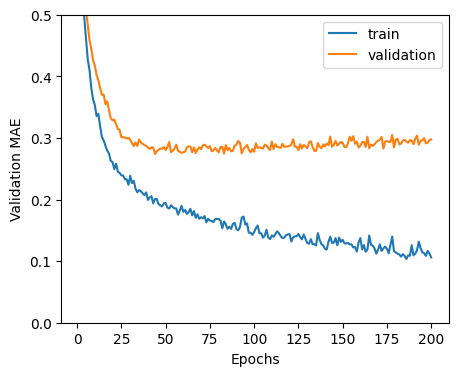

In [48]:
epochs = range(1, len(average_mae_history) + 1)
plt.figure(figsize=(5,4))
plt.plot(epochs, history.history['mean_absolute_error'], label="train")
plt.plot(epochs, average_mae_history, label="validation")
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.ylim([0, 0.5])
plt.legend()
plt.show()

## Prediction

In [57]:
X_test_samples = x_test[0:3]
# x_test_normalized = (X_test_samples - mean) / std
preds = model.predict(X_test_samples)
preds_dollar = [np.round(x*100_000, 3) for x in preds]
for pred in preds_dollar:
    print(f'{pred[0]:,}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
245,644.3125
169,062.53125
122,766.78125


In [61]:
test_labels = y_test[0:3] * 100_000
for label in test_labels:
    print(f'{label:,}')

218,800.0
218,400.0
93,800.0
